In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
# Load the crimes by day and hour dataframe
df = pd.read_csv('CSV Dataset/Crimes_comb.csv', index_col=[0], parse_dates=['Date'])

In [3]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
0,10457545,HZ190268,2016-03-17 06:00:00,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,GOVERNMENT BUILDING/PROPERTY,1654,16,41,76,18,2016,NaN,NaN
1,10425678,HZ156460,2016-02-18 19:41:45,043XX W GLADYS AVE,2027,NARCOTICS,POSS: CRACK,RESIDENCE,1131,11,28,26,18,2016,NaN,NaN
2,10538622,HZ283084,2016-05-27 15:00:00,023XX N CLARK ST,0620,BURGLARY,UNLAWFUL ENTRY,ATHLETIC CLUB,1814,18,43,7,05,2016,41.924225,-87.639639
3,11914609,JC538182,2016-01-20 00:01:00,039XX W 66TH ST,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,833,8,13,65,17,2016,NaN,NaN
4,10883231,JA193135,2016-05-23 00:00:00,016XX S MORGAN ST,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,1235,12,25,31,17,2016,41.859572,-87.650932


###### We can drop useful information like 'Location description' because 'IUCR' is directly linked to the 'Primary Type' and 'Description'. 'Longtitude' and 'Latitude' can be dropped since information from 'Beat', 'District', 'Ward'  and 'Community Area' can be used instead.

In [4]:
df.drop(['ID', 'Case Number', 'Block', 'Year', 'Location Description', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [5]:
# Drop non-criminal crimes
df = df[df['Primary Type'] != 'NON - CRIMINAL']
df = df[df['Primary Type'] != 'NON-CRIMINAL']
df = df[df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']

In [6]:
# Extract month, hour, and weekday
df.insert(loc=0, column='Month', value=pd.DatetimeIndex(df['Date']).month)
df.insert(loc=1, column='Hour', value=(df['Date'].dt.hour + (df['Date'].dt.minute / 60) + (df['Date'].dt.second / 3600)))
df.insert(loc=2, column='Weekday', value=pd.DatetimeIndex(df['Date']).weekday)

In [7]:
# Since month, hour, and weekday have been extracted, 'Date' won't be needed anymore.
df.drop(['Date'], axis=1, inplace=True)

In [8]:
# Check for the datatypes
df.dtypes

Month               int64
Hour              float64
Weekday             int64
IUCR               object
Primary Type       object
Description        object
Beat                int64
District            int64
Ward                int64
Community Area      int64
FBI Code           object
dtype: object

###### Eventhough 'IUCR' and 'FBI Code' seems to contain only integers, it does not. 'IUCR' and 'FBI Code' will have to be preprocessed using LabelEncoder along with 'Description'.

In [9]:
# Check the 'IUCR' to see if the whole column is composed of numeric values
all(df['IUCR'].str.isnumeric())

False

In [10]:
# Check the 'FBI Code' to see if the whole column is composed of numeric values
all(df['FBI Code'].str.isnumeric())

False

# PCA Analysis

In [11]:
#Pre-check for Theft
df_theft = df[(df['Primary Type'] == 'THEFT')].copy()

In [12]:
# Drop the 'Primary Type' column
df_theft.drop(['Primary Type'], axis=1, inplace=True)

In [13]:
df_theft.head()

,Month,Hour,Weekday,IUCR,Description,Beat,District,Ward,Community Area,FBI Code
44,2,9.000000,2,0810,OVER $500,834,8,18,70,06
56,2,8.400000,5,0820,$500 AND UNDER,1532,15,28,25,06
89,3,22.000000,6,0890,FROM BUILDING,1831,18,42,8,06
147,1,22.000000,2,0810,OVER $500,723,7,20,68,06
150,7,0.016667,4,0810,OVER $500,1822,18,27,8,06


In [14]:
# Create a list of features
features = []

for i in df_theft.columns:
    if i != 'Month':
        features.append(i)

In [15]:
# Label encode the categorical values
le = LabelEncoder()

In [16]:
# Encode labels in column 'IUCR', Description', 'Location Description', and 'FBI Code'
df_theft.loc[:, 'IUCR']= le.fit_transform(df_theft.loc[:, 'IUCR']) 
df_theft.loc[:, 'Description']= le.fit_transform(df_theft.loc[:, 'Description']) 
df_theft.loc[:, 'FBI Code']= le.fit_transform(df_theft.loc[:, 'FBI Code']) 

In [17]:
df_theft.head()

,Month,Hour,Weekday,IUCR,Description,Beat,District,Ward,Community Area,FBI Code
44,2,9.000000,2,0,5,834,8,18,70,0
56,2,8.400000,5,1,0,1532,15,28,25,0
89,3,22.000000,6,8,3,1831,18,42,8,0
147,1,22.000000,2,0,5,723,7,20,68,0
150,7,0.016667,4,0,5,1822,18,27,8,0


In [18]:
# Set x
x = df_theft.loc[:, features].values

In [19]:
# Use StandardScaler to fit and transform
x = StandardScaler().fit_transform(x)

In [20]:
# Set the PCA components to 2
pca = PCA(n_components=2)

In [21]:
# Use PCA to fit and trasnform standardized data
principalComponents = pca.fit_transform(x)

In [22]:
# Geneate a new dataframe for the PCA components
principal_df = pd.DataFrame(data=principalComponents, 
                            columns=['principal component 1', 
                                    'principal component 2'])

In [23]:
# Include the 'target' variable column, in this case - Month
principal_df['target'] = df_theft['Month'].values

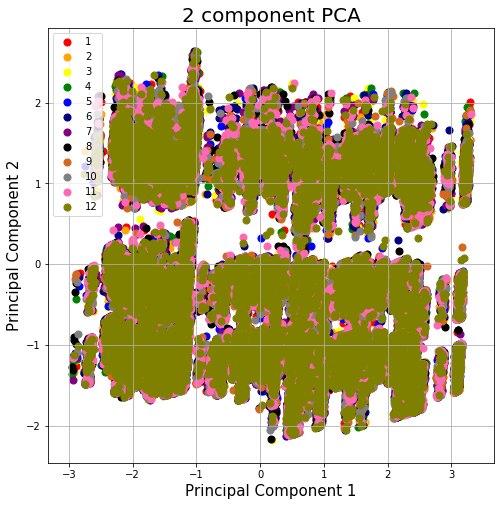

In [24]:
# Visualize the PCA data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'black', 'chocolate', 'gray', 'hotpink', 'olive']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['target'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# KNN Classifier

In [25]:
# Create arrays including unique values for districts and primary types
district_arr = np.sort(df['District'].unique())
crime_arr = np.sort(df['Primary Type'].unique())

In [26]:
df.head()

,Month,Hour,Weekday,IUCR,Primary Type,Description,Beat,District,Ward,Community Area,FBI Code
0,3,6.000000,3,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,1654,16,41,76,18
1,2,19.695833,3,2027,NARCOTICS,POSS: CRACK,1131,11,28,26,18
2,5,15.000000,4,0620,BURGLARY,UNLAWFUL ENTRY,1814,18,43,7,05
3,1,0.016667,2,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,833,8,13,65,17
4,5,0.000000,0,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,1235,12,25,31,17


In [27]:
# Define a method for classifying every crime in each district using KNeighborsClassifier
def knn_classify(crime, district):
    # Set the dataframe appropriately for the KNN algorithm
    df_knn = df.loc[df['Primary Type'] == crime]
    df_knn = df_knn.loc[df_knn['District'] == district]   
    
    # Label encode the 'IUCR', 'Description', and 'FBI Code' column
    le = LabelEncoder()
    
    df_knn.loc[:, 'IUCR']= le.fit_transform(df_knn.loc[:, 'IUCR']) 
    df_knn.loc[:, 'Description']= le.fit_transform(df_knn.loc[:, 'Description']) 
    df_knn.loc[:, 'FBI Code']= le.fit_transform(df_knn.loc[:, 'FBI Code']) 
    
    # Define X and y values
    X = df_knn.drop(['Month', 'Primary Type', 'District'], axis=1).values
    y = df_knn.Month.values
    
    # Set the minimum threshold data to more than 50
    if len(X) <= 50 :
        print(crime.capitalize(), 'has neither occurred in the District', district, 'or too few occurrences')
        return
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
        knn = KNeighborsClassifier(n_neighbors=12)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        print(crime.capitalize(), 'from District', district, ': %.2f' % accuracy_score(y_test, y_pred))

In [28]:
# Loop through every crime in each district using KNeighborsClassifier
for crime in crime_arr:
    for district in district_arr:
        knn_classify(crime, district)

Arson has neither occurred in the District 1 or too few occurrences
Arson has neither occurred in the District 2 or too few occurrences
Arson has neither occurred in the District 3 or too few occurrences
Arson from District 4 : 0.15
Arson from District 5 : 0.07
Arson from District 6 : 0.05
Arson from District 7 : 0.09
Arson from District 8 : 0.03
Arson from District 9 : 0.11
Arson from District 10 : 0.11
Arson from District 11 : 0.23
Arson has neither occurred in the District 12 or too few occurrences
Arson has neither occurred in the District 14 or too few occurrences
Arson from District 15 : 0.22
Arson has neither occurred in the District 16 or too few occurrences
Arson has neither occurred in the District 17 or too few occurrences
Arson has neither occurred in the District 18 or too few occurrences
Arson has neither occurred in the District 19 or too few occurrences
Arson has neither occurred in the District 20 or too few occurrences
Arson has neither occurred in the District 22 or 

Criminal trespass from District 14 : 0.05
Criminal trespass from District 15 : 0.10
Criminal trespass from District 16 : 0.11
Criminal trespass from District 17 : 0.08
Criminal trespass from District 18 : 0.09
Criminal trespass from District 19 : 0.07
Criminal trespass from District 20 : 0.10
Criminal trespass from District 22 : 0.08
Criminal trespass from District 24 : 0.10
Criminal trespass from District 25 : 0.11
Criminal trespass has neither occurred in the District 31 or too few occurrences
Deceptive practice from District 1 : 0.09
Deceptive practice from District 2 : 0.09
Deceptive practice from District 3 : 0.10
Deceptive practice from District 4 : 0.09
Deceptive practice from District 5 : 0.08
Deceptive practice from District 6 : 0.08
Deceptive practice from District 7 : 0.05
Deceptive practice from District 8 : 0.07
Deceptive practice from District 9 : 0.09
Deceptive practice from District 10 : 0.12
Deceptive practice from District 11 : 0.10
Deceptive practice from District 12

Intimidation has neither occurred in the District 12 or too few occurrences
Intimidation has neither occurred in the District 14 or too few occurrences
Intimidation has neither occurred in the District 15 or too few occurrences
Intimidation has neither occurred in the District 16 or too few occurrences
Intimidation has neither occurred in the District 17 or too few occurrences
Intimidation has neither occurred in the District 18 or too few occurrences
Intimidation has neither occurred in the District 19 or too few occurrences
Intimidation has neither occurred in the District 20 or too few occurrences
Intimidation has neither occurred in the District 22 or too few occurrences
Intimidation has neither occurred in the District 24 or too few occurrences
Intimidation has neither occurred in the District 25 or too few occurrences
Intimidation has neither occurred in the District 31 or too few occurrences
Kidnapping has neither occurred in the District 1 or too few occurrences
Kidnapping has 

Offense involving children from District 9 : 0.13
Offense involving children from District 10 : 0.11
Offense involving children from District 11 : 0.07
Offense involving children from District 12 : 0.14
Offense involving children from District 14 : 0.17
Offense involving children from District 15 : 0.13
Offense involving children from District 16 : 0.12
Offense involving children from District 17 : 0.14
Offense involving children from District 18 : 0.08
Offense involving children from District 19 : 0.16
Offense involving children from District 20 : 0.16
Offense involving children from District 22 : 0.13
Offense involving children from District 24 : 0.10
Offense involving children from District 25 : 0.17
Offense involving children has neither occurred in the District 31 or too few occurrences
Other offense from District 1 : 0.11
Other offense from District 2 : 0.09
Other offense from District 3 : 0.08
Other offense from District 4 : 0.11
Other offense from District 5 : 0.10
Other offens

Stalking has neither occurred in the District 8 or too few occurrences
Stalking has neither occurred in the District 9 or too few occurrences
Stalking has neither occurred in the District 10 or too few occurrences
Stalking has neither occurred in the District 11 or too few occurrences
Stalking has neither occurred in the District 12 or too few occurrences
Stalking has neither occurred in the District 14 or too few occurrences
Stalking has neither occurred in the District 15 or too few occurrences
Stalking has neither occurred in the District 16 or too few occurrences
Stalking has neither occurred in the District 17 or too few occurrences
Stalking has neither occurred in the District 18 or too few occurrences
Stalking has neither occurred in the District 19 or too few occurrences
Stalking has neither occurred in the District 20 or too few occurrences
Stalking has neither occurred in the District 22 or too few occurrences
Stalking has neither occurred in the District 24 or too few occurr

# Random Forest

In [29]:
# Color palette for the confusion matrix
pal = sns.cubehelix_palette(8)

In [30]:
df_dtc = df.loc[df['Primary Type'] == 'ARSON']

###### Since it is not cost effective to GridSearchCV on Random Forest for every district within the crime, all districts will be combined.

In [31]:
# Define a method for classifying every crime in each district using RandomForestClassifier
def dtc_classify(crime):
    # Select the dataframe with the given crime
    df_dtc = df.loc[df['Primary Type'] == crime].copy()
    
    # Label encode the 'IUCR', 'Description', and 'FBI Code' column
    le = LabelEncoder()
    
    df_dtc.loc[:, 'IUCR']= le.fit_transform(df_dtc.loc[:, 'IUCR']) 
    df_dtc.loc[:, 'Description']= le.fit_transform(df_dtc.loc[:, 'Description']) 
    df_dtc.loc[:, 'FBI Code']= le.fit_transform(df_dtc.loc[:, 'FBI Code']) 
    
    # Define X and y values
    X = df_dtc.drop(['Month', 'Primary Type'], axis=1).values
    y = df_dtc.Month.values
    
    # Set GridSearchCV parameters
    grid_params = {'n_estimators':[50, 100, 150], 'max_depth':[5, 10, 15]}
    
    # Set the minimum threshold data to more than 50
    if len(X) <= 50 :
        print(crime.capitalize(), 'has too few occurrences')
        return
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
        model = GridSearchCV(RandomForestClassifier(random_state=3), grid_params, cv=3, iid=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, cmap=pal, fmt="d", xticklabels=np.arange(1,13), yticklabels=np.arange(1,13))
        plt.xlabel('Predicted month')
        plt.ylabel('Actual month')
        plt.title('Confusion Matrix for ' + str(crime.capitalize()))
        plt.show()
        
        print('Accuracy score: %.2f' % accuracy_score(y_test, y_pred))

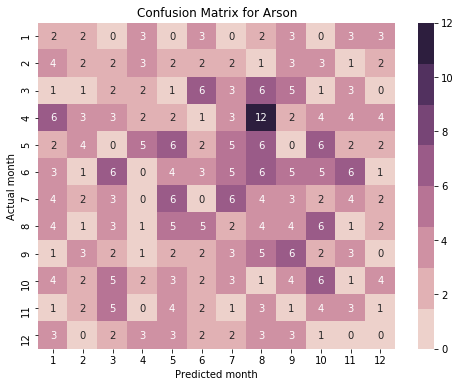

Accuracy score: 0.10


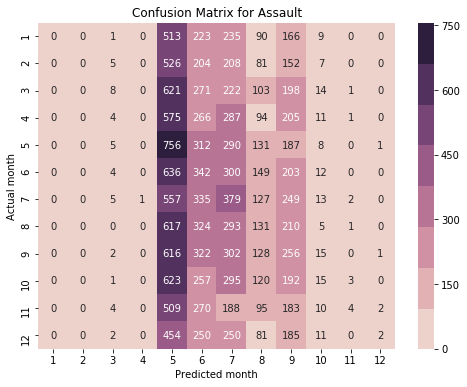

Accuracy score: 0.11


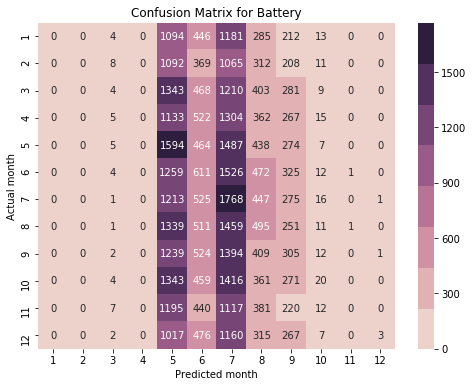

Accuracy score: 0.11


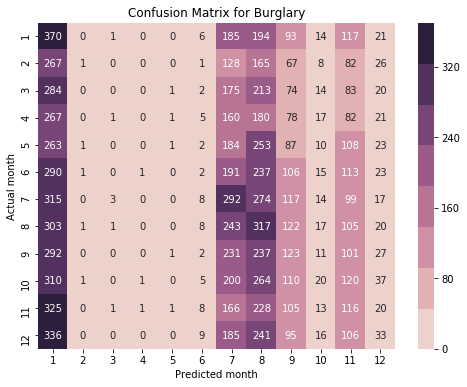

Accuracy score: 0.11


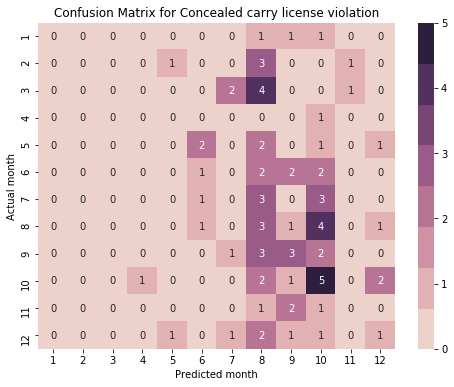

Accuracy score: 0.17


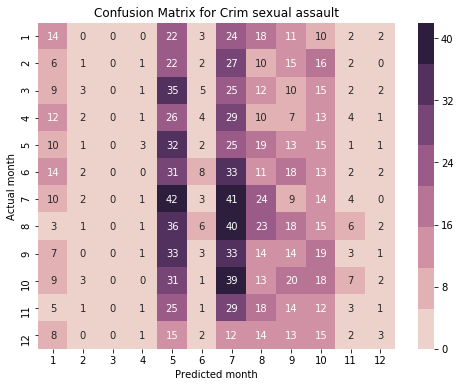

Accuracy score: 0.11


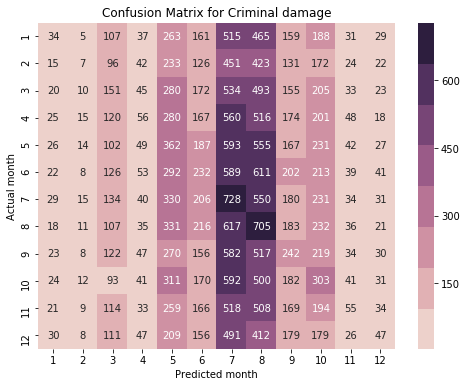

Accuracy score: 0.11


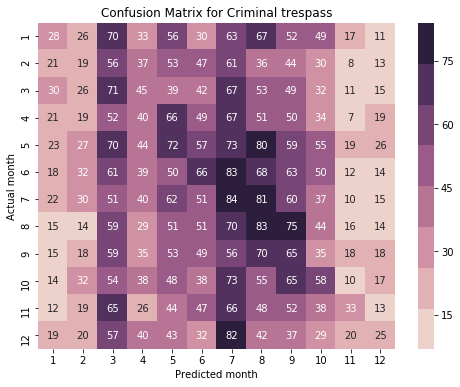

Accuracy score: 0.11


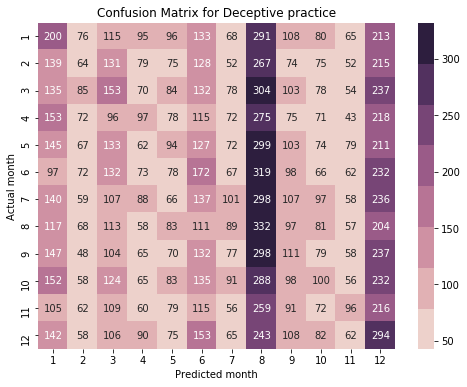

Accuracy score: 0.10


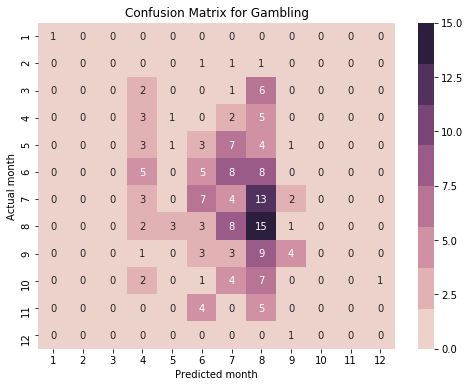

Accuracy score: 0.19


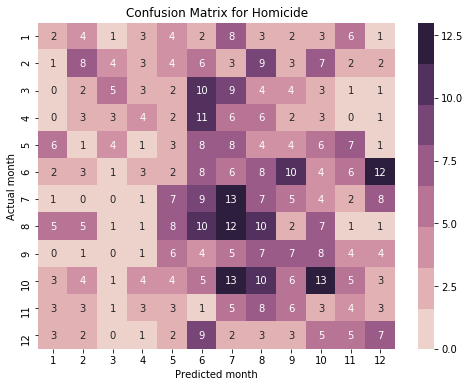

Accuracy score: 0.14
Human trafficking has too few occurrences


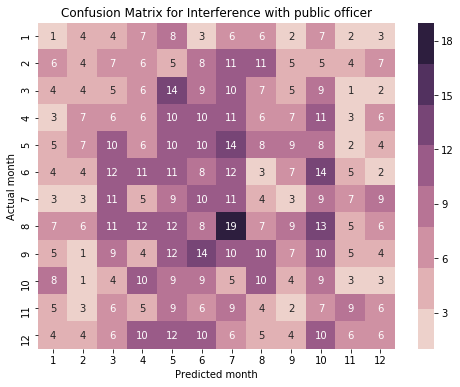

Accuracy score: 0.08


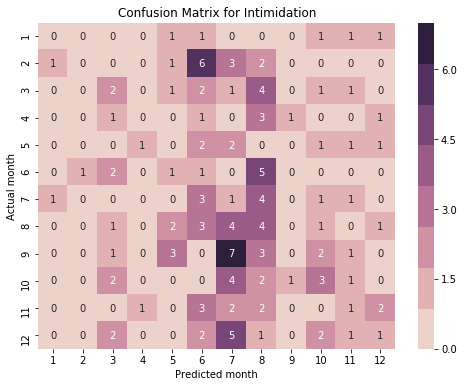

Accuracy score: 0.09


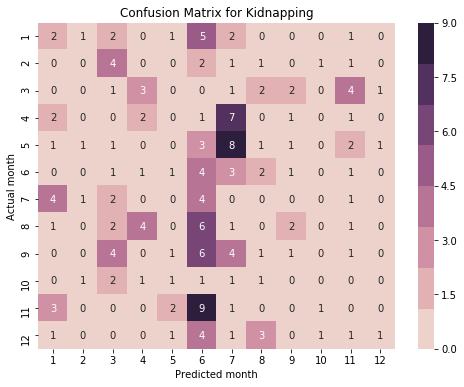

Accuracy score: 0.07


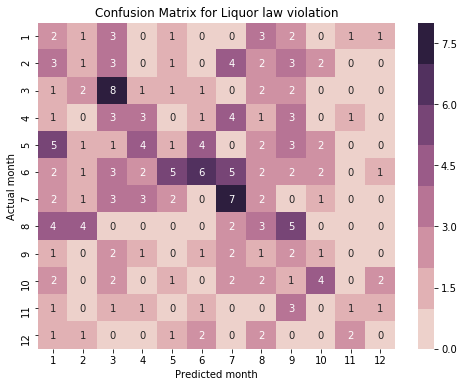

Accuracy score: 0.18


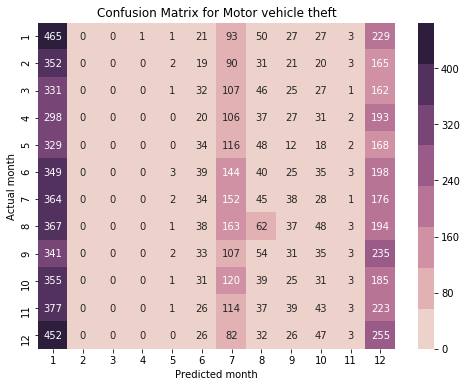

Accuracy score: 0.11


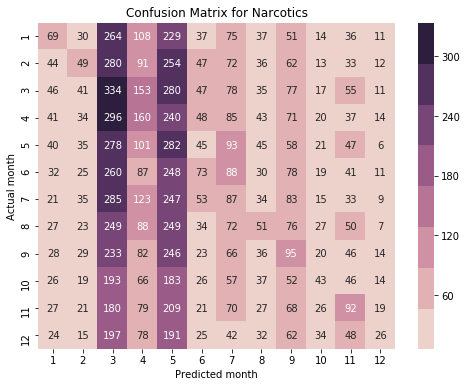

Accuracy score: 0.12


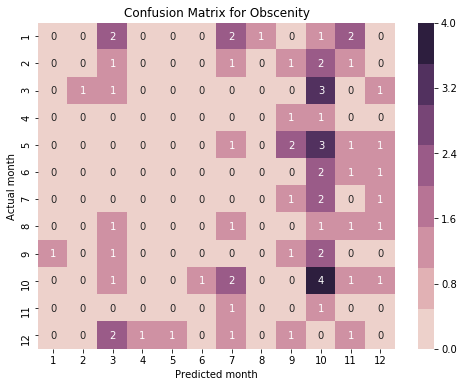

Accuracy score: 0.09


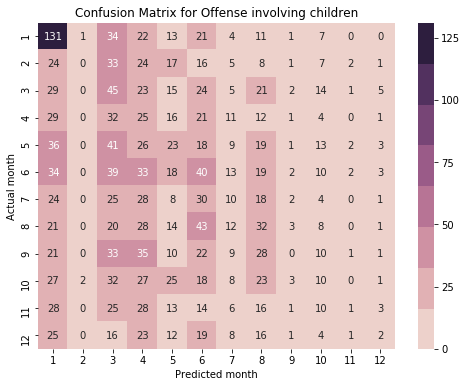

Accuracy score: 0.15


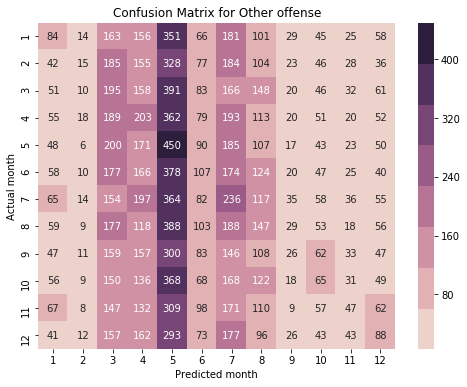

Accuracy score: 0.11


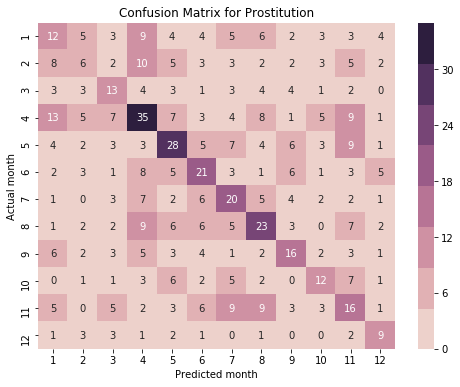

Accuracy score: 0.31
Public indecency has too few occurrences


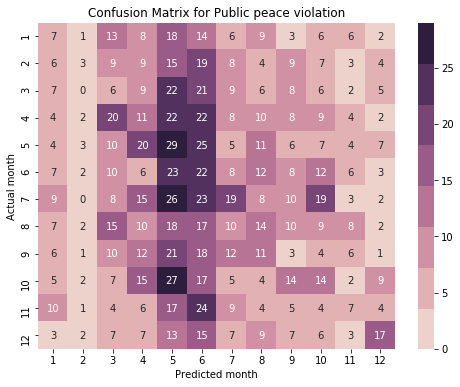

Accuracy score: 0.11


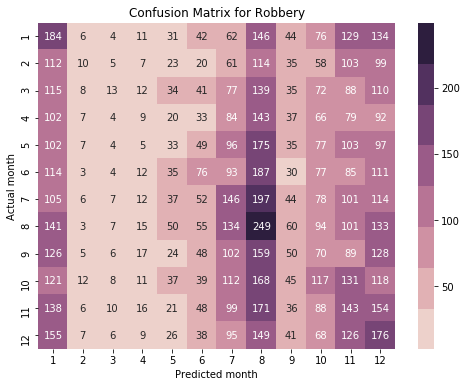

Accuracy score: 0.12


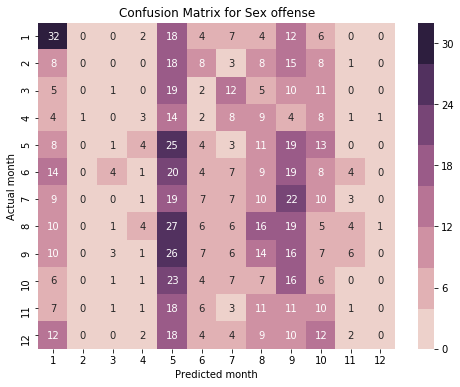

Accuracy score: 0.12


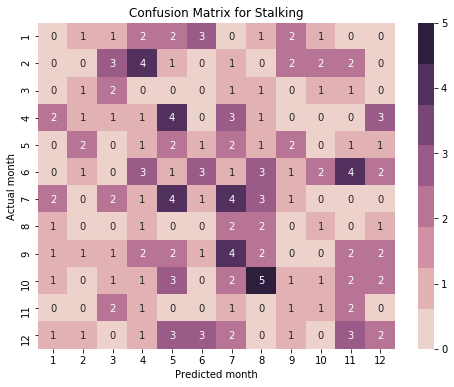

Accuracy score: 0.11


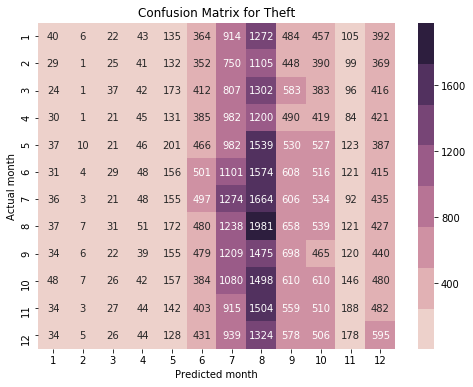

Accuracy score: 0.11


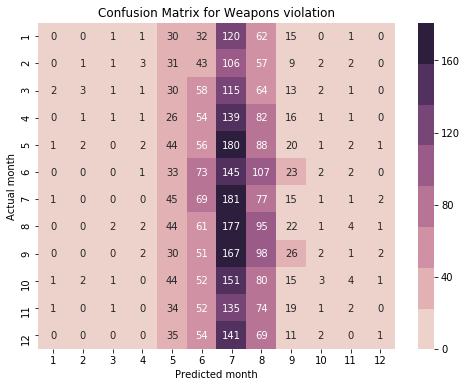

Accuracy score: 0.10


In [32]:
# Loop through every crime in each district using RandomForestClassifier
for crime in crime_arr:
    dtc_classify(crime)